In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
font = {'size'   : 15}
matplotlib.rc('font', **font)

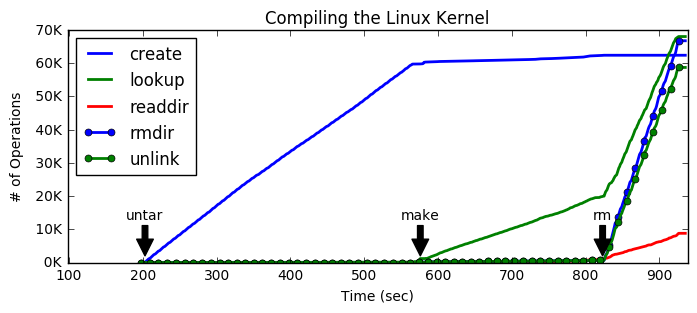

In [120]:
def read_timeseries(metric, label):
    args  = {'skiprows' : 13, 'names': ["index", "Time (sec)", label]}
    fname = '../results/' + metric + '.wsp.out'
    try:
        df = pd.read_csv(fname, **args)
    except:
        sys.exit("Create time series (" + fname + ") does not exist, "+
                 "please cd to experiments/baseline-compile/visualize and run ./plot.sh")    
    del df['index']
    df = df[df['Time (sec)'] != 0]
    return df

# parse into data frames
df = read_timeseries('req_create', 'create')
for req in ['readdir', 'lookup', 'unlink', 'rmdir']:
    df = pd.merge(df, read_timeseries('req_'+req, req), on='Time (sec)')
df = df[df['create'] > 11] # lop off the beginning of the trace

# plot the graph
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
args = {'ax': ax, 'x': 'Time (sec)', 'lw': 2, 'colors': ['blue', 'green', 'red']}
df.plot(y=['create', 'lookup', 'readdir'], **args)
df.plot(y=['rmdir', 'unlink'], marker='o', markersize=5, markevery=10, **args)

# annotate graph with job phases
def plot_phases(ax, df, fname, jobs=['untar', 'make', 'rm'], y0=2000, y1=13000):
    def to_seconds(timestamp):
        ts = timestamp.split(':')
        return int(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    
    runtimes = pd.read_csv(fname)
    runtimes['label'] = ['download', 'untar', 'config', 'make', 'ls', 'rm']    
    t = int(df['Time (sec)'].head(1))    
    for index, row in runtimes.iterrows():
        sec = to_seconds(row['delta'])
        if row['label'] in jobs:
            ax.annotate(row['label'], xy=(t, y0), xytext=(t, y1),
                        ha='center', arrowprops=dict(facecolor='black'))
        t += sec
        
plot_phases(ax, df, '../results/compile-threads-4-issdm-0-2017-11-10-20:02:55.txt')
ax.set_ylabel("# of Operations")
ax.set_yticklabels(['{:3.0f}K'.format(y/1000) for y in ax.get_yticks()])
ax.set_xticklabels(range(0, 1000, 100))
ax.set_xlim(1510373598 - 100, 1510373598 + 740)
ax.set_title("Compiling the Linux Kernel") 
fig.savefig('../../../paper/figures/compile-ops.png', bbox_inches='tight', dpi=400)

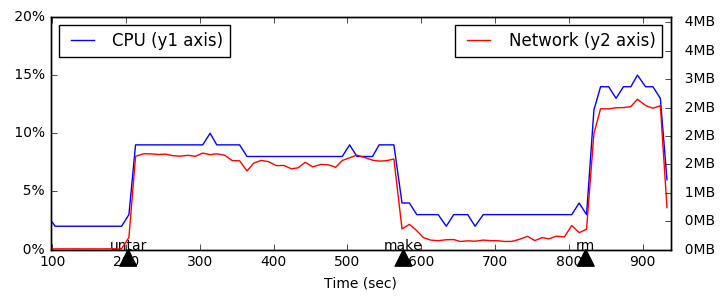

In [122]:
# parse CPU utilization into data frames
df_util = read_timeseries('user', 'CPU (y1 axis)')
for req in ['kbin', 'kbout']:
    df_util = pd.merge(df_util, read_timeseries(req, req), on='Time (sec)')
df_util['Network (y2 axis)'] = df_util['kbin'] + df_util['kbout']

# plot the graph
fig, ax0 = plt.subplots(1, 1, figsize=(8, 3))
ax1 = ax0.twinx()
df_util.plot(y=['CPU (y1 axis)']   , ax=ax0, x='Time (sec)', color='blue')
df_util.plot(y=['Network (y2 axis)'], ax=ax1, x='Time (sec)', color='red')
plot_phases(ax0, df,
            '../results/compile-threads-4-issdm-0-2017-11-10-20:02:55.txt',
            y0=0, y1=0)


ax0.set_ylim(0, 20)
ax0.set_yticklabels(['{:3.0f}%'.format(y) for y in ax0.get_yticks()])
ax0.legend(loc='upper left')

ax1.set_ylim(0, 4096)
ax1.set_yticklabels(['{:3.0f}MB'.format(y/1000) for y in ax1.get_yticks()])
ax1.legend(loc='upper right')
for ax in [ax0, ax1]:
    ax.set_xticklabels(range(0, 1000, 100))
    ax.set_xlim(1510373598 - 100, 1510373598 + 740)
    

#df.plot(y=['rmdir', 'unlink'], marker='o', markersize=5, markevery=10, **args)
